In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats

DIR = "/home/julian/Documents/ndnrtc_testing/evaluation/reTrans_evaluation_results"

# read in csv file
df = pd.read_csv(DIR + '/run_overview.csv', delimiter='\t', index_col=False)

# transform columns names to lower case
df.columns = [col.lower() for col in df]

# ensuring backwards compatibility
df.rename(columns={"adaption":"init._res."}, inplace=True)

# ensuring forwards compatibility
df.rename(columns={"retr._total":"retransmissions", 
                   "al_seq.len.":"al_seq_len"}, inplace=True)

# remove unnecessary columns
df.drop(columns=["retr._max"], inplace=True)

df.head()

,setting,run,init._res.,adaption_logic,shaping_profile,bandwith(cons),al_w1,al_w2,al_th1,al_th2,al_seq_len,frames_missing,retransmissions,psnr,ssim,vmaf
0,1,0,med,ReTrans,HLH,-----,0.7,1.3,1,3,1,1051,931,15.23,0.694953,38.218117
1,1,1,med,ReTrans,HLH,-----,0.7,1.3,1,3,1,976,500,19.19,0.677450,37.759937
2,1,2,med,ReTrans,HLH,-----,0.7,1.3,1,3,1,646,595,16.27,0.573160,38.615331
3,1,3,med,ReTrans,HLH,-----,0.7,1.3,1,3,1,506,832,14.65,0.574026,38.893652
4,1,4,med,ReTrans,HLH,-----,0.7,1.3,1,3,1,527,1339,15.11,0.535138,39.707945


In [2]:
def customFilter (df, al_w1_fixed, al_w2_fixed, al_th1_fixed, al_th2_fixed, al_seq_len_fixed):
   
    # filter data according to fixed parameters
    df_tmp = df[(df.al_w1 == al_w1_fixed) 
             & (df.al_w2 == al_w2_fixed)
             & (df.al_th1 == al_th1_fixed) 
             & (df.al_th2 == al_th2_fixed)
             & (df.al_seq_len == al_seq_len_fixed)]
    
    return df_tmp

In [3]:
def convertThreadToInt(thread):
    if thread == 'low':
        return 3000
    if thread == 'med':
        return 4000
    if thread == 'high':
        return 10000

In [4]:
# find good example run of winning setting
tmp = customFilter(df, 0.7, 1.3, 1, 3, 5)
tmp_winner = tmp[(tmp.setting <= 300) & (tmp.shaping_profile == "HLH")].sort_values("vmaf", ascending=False)
setting = tmp_winner["setting"].head(1).iloc[0]
run = tmp_winner["run"].head(1).iloc[0]

In [5]:
# read txt file for intermediates data
DIR_HD = "/media/julian/extHD"
df_inter = pd.read_csv(DIR_HD + '/setting_' + str(setting) 
                      + '/intermediates/' 
                      + '/0_1_8000.txt',
                      sep='[\t,]', engine='python', 
                      index_col=False)

# duplicate last row to have a value at 60s too
df_inter.at[len(df_inter.index)] = [60.0, 0.0, 0.0, df_inter[' rate'].iloc[-1]]
df_inter

,start,delay,loss random,rate
0,0.0,0.0,0.0,13500.0
1,8.0,0.0,0.0,7500.0
2,16.0,0.0,0.0,4500.0
3,24.0,0.0,0.0,3000.0
4,32.0,0.0,0.0,4500.0
5,40.0,0.0,0.0,7500.0
6,48.0,0.0,0.0,13500.0
7,56.0,0.0,0.0,7500.0
8,60.0,0.0,0.0,7500.0


In [6]:
# read csv file for run data
DIR_HD = "/media/julian/extHD"
df_run = pd.read_csv(DIR_HD + '/setting_' + str(setting) 
                      + '/results/' + str(run) 
                      + '/arcLog_threadswitches.csv',
                      sep='[\t:]', engine='python', 
                      index_col=False)

# save start time and initial resolution in variables
startTime = int(df_run.columns[3])
initRes = df_run.columns[-1]

# throw away unecessary columns
df_run = df_run [df_run.columns[0:4]]

# rename remaining columns
columns = ['absolute_time', 'category', 'action', 'threads']
df_run.columns=columns

# subtract start time from absolute times get relative times
df_run['relative_time'] = [(row - startTime) / 1000 for row in df_run['absolute_time']]

# throw away uncesessary rows
df_run = df_run[df_run.action == ' [switchingThread]']

# duplicate last row to have a value at 60s too
df_run = df_run.append(df_run.iloc[-1], ignore_index=True)
df_run.at[df_run.index[-1], 'relative_time'] = 60.0

# add row to beginning to have a value at 0s too
df_row = {'absolute_time' : startTime,
         'category' : ' [INFO ]',
         'action' : '[initalThread]',
         'threads' : initRes,
         'relative_time' : 0.0}
df_run = df_run.append(df_row, ignore_index=True)

# sort all the rows and re-index
df_run = df_run.sort_values('relative_time').reset_index(drop=True)

# convert threads to numbers
df_run['threads'] = [convertThreadToInt(thread) for thread in df_run['threads']]

df_run

,absolute_time,category,action,threads,relative_time
0,1573216302202,[INFO ],[initalThread],4000,0.000
1,1573216312088,[INFO ],[switchingThread],10000,9.886
2,1573216324079,[INFO ],[switchingThread],4000,21.877
3,1573216329344,[INFO ],[switchingThread],3000,27.142
4,1573216347079,[INFO ],[switchingThread],4000,44.877
5,1573216352086,[INFO ],[switchingThread],10000,49.884
6,1573216352086,[INFO ],[switchingThread],10000,60.000


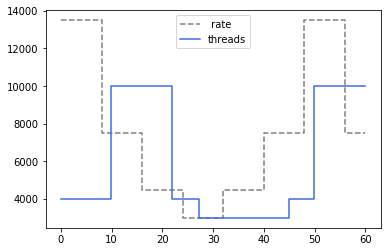

In [7]:
plt.step(df_inter['start'], df_inter[' rate'], where='post', color='gray', linestyle='--')
plt.step(df_run['relative_time'], df_run['threads'], where='post', color='royalblue')

#axes = plt.gca()
#axes.set_xlim([0,60])
plt.legend()